In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split

# Plots
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:

df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [4]:
df_X_train = df_train.drop(labels=["label"], axis=1)
df_y_train = df_train["label"]
del df_train

In [5]:
label_counts = df_y_train.value_counts().sort_index()
num_labels = label_counts.shape[0]

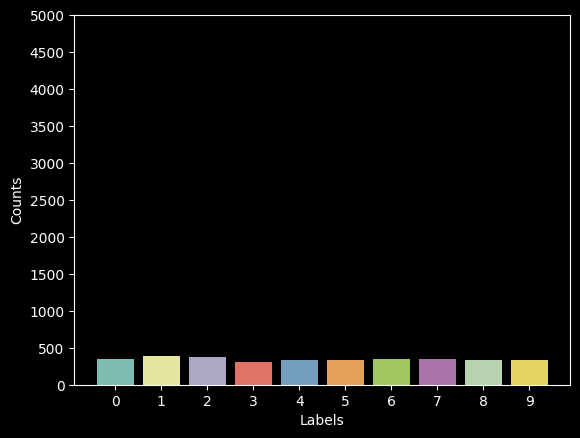

In [6]:
mpl.style.use('dark_background')
# mpl.rcParams.update({'font.size': 16, 'text.usetex': True})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:num_labels]
fig, ax = plt.subplots()

bar_labels = [str(x) for x in range(0, 10)]
bar_counts = [x for x in label_counts]

ax.bar(bar_labels, bar_counts, label=bar_labels, color=colors, alpha=0.9)
ax.set_xlabel('Labels')
ax.set_ylabel('Counts')
ax.set_yticks(np.arange(0,5500, 500))
plt.show()

In [7]:
# use validation size of 10% of the training dataset
validation_size = 0.1
X_train, y_train = df_X_train.to_numpy(), df_y_train.to_numpy()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=validation_size, shuffle=True, random_state=1, stratify=y_train)

In [8]:
print(f"Training:\t{X_train.shape[0]}")
print(f"Validation:\t{X_valid.shape[0]}")

Training:	3093
Validation:	344


In [9]:
first_images = X_train[:100].reshape((-1,28,28)).astype(np.uint8)
first_images_labels = y_train[:100].astype(np.uint8)

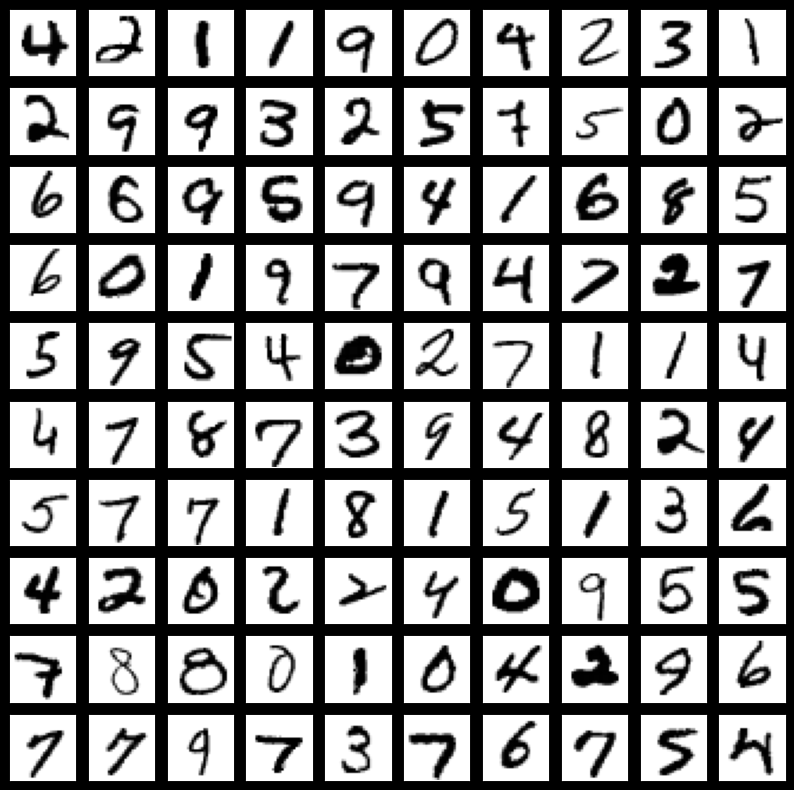

In [10]:
mpl.style.use('dark_background')
fig = plt.figure(figsize=(10,10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    img = first_images[i]
    ax.imshow(img, cmap='gray_r')
plt.show()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(f'Using device: {device}')

Using device: cuda


In [12]:
torch.set_default_device(device)
torch.manual_seed(0)

In [13]:
# Reshape input
X_train, y_train = X_train.reshape(
    (-1, 1, 28, 28)).astype(np.float32), y_train.astype(np.uint8)
X_valid, y_valid = X_valid.reshape(
    (-1, 1, 28, 28)).astype(np.float32), y_valid.astype(np.uint8)

In [14]:
print(f"X_train: {X_train.shape}\nX_valid: {X_valid.shape}")

X_train: (3093, 1, 28, 28)
X_valid: (344, 1, 28, 28)


In [15]:
# Transform to PyTorch Tensor
X_train, y_train = torch.from_numpy(X_train), torch.from_numpy(y_train)
X_valid, y_valid = torch.from_numpy(X_valid), torch.from_numpy(y_valid)
print(f"X_train: {X_train.shape}\nX_valid: {X_valid.shape}")

X_train: torch.Size([3093, 1, 28, 28])
X_valid: torch.Size([344, 1, 28, 28])


In [16]:
from enum import Enum

num_augments = 10


class DatasetType(Enum):
    TRAIN = 0,
    VALID = 1,
    TEST = 2


class MNIST_data(Dataset):
    def __init__(self, X, y=None, set_type=DatasetType.TRAIN, device=None):
        normalize = v2.Normalize(mean=(0.5,), std=(0.5,))
        randomAffine = v2.RandomAffine(degrees=(-45, 45), translate=(0.1, 0.1))

        X = X.to(device)
        X = normalize(X)
        if set_type is DatasetType.TRAIN:
            X_aug = torch.empty(size=(len(X) * (num_augments), 1, 28, 28))
            count = 0
            for idx_aug in range(num_augments):
                print(f"Augment {idx_aug + 1}")
                for idx in range(len(X)):
                    X_aug[count] = randomAffine(X[idx])
                    count += 1
            self.X = torch.vstack((X, X_aug)).to(device)
            self.y = y.repeat(num_augments + 1).to(device)

        else:
            self.X = X.to(device)
            if y is not None:
                self.y = y.to(device)

        print('', end='\r')

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [19]:
!pip install --upgrade torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.3 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.19.0+cu121
    Uninstalling torchvision-0.19.0+cu121:
      Successfully uninstalled torchvision-0.19.0+cu121


In [17]:
train_ds = MNIST_data(X_train, y_train, DatasetType.TRAIN, device = device)
valid_ds = MNIST_data(X_valid, y_valid, DatasetType.VALID, device = device)

Augment 1
Augment 2
Augment 3
Augment 4
Augment 5
Augment 6
Augment 7
Augment 8
Augment 9
Augment 10


In [18]:
batch_size = 64
generator = torch.Generator(device)
train_dl = DataLoader(train_ds, batch_size, shuffle=True, generator = generator)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, generator = generator)

In [19]:
print(f"Augmented train size: {len(train_dl.dataset)}")

Augmented train size: 34023


In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (bn3): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [30]:
# Convert y_batch to torch.long
x_batch, y_batch = x_batch.to(device), y_batch.to(device).long()


In [33]:
print(f"Input batch data: {x_batch}")
print(f"Min value in batch: {x_batch.min()}")
print(f"Max value in batch: {x_batch.max()}")


Input batch data: tensor([[[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ..., -1.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]],


        [[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ..., -1.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]],


        [[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ..., -1.,  0.,  0.],
          [ 0.,  0.,  0.,  ..., -1.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ..., -1., -1., -1.],
          [ 0.,  0.,  0.,  ..., -1., -1., -1.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]],


        ...,


        [[[ 0.,  0., -1.,  ...,  0.,  0.,  0.]

In [34]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


tensor(0., device='cuda:0')

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Reduce learning rate


In [36]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)

model.apply(init_weights)

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (bn3): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [38]:
# Instead of BatchNorm2d
bn1 = nn.GroupNorm(32, 32)

In [41]:
x_batch = x_batch / 255.0  # If max value is 255


In [42]:
for epoch in range(num_epochs):
    for i, (x_batch, y_batch) in enumerate(train_dl):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device).long()
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)

        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN or Inf detected in loss at epoch {epoch+1}, batch {i+1}")
            break  # This break needs to be inside a loop

        loss.backward()
        optimizer.step()

NaN or Inf detected in loss at epoch 1, batch 1
NaN or Inf detected in loss at epoch 2, batch 1
NaN or Inf detected in loss at epoch 3, batch 1
NaN or Inf detected in loss at epoch 4, batch 1
NaN or Inf detected in loss at epoch 5, batch 1
NaN or Inf detected in loss at epoch 6, batch 1
NaN or Inf detected in loss at epoch 7, batch 1
NaN or Inf detected in loss at epoch 8, batch 1
NaN or Inf detected in loss at epoch 9, batch 1
NaN or Inf detected in loss at epoch 10, batch 1
NaN or Inf detected in loss at epoch 11, batch 1
NaN or Inf detected in loss at epoch 12, batch 1
NaN or Inf detected in loss at epoch 13, batch 1
NaN or Inf detected in loss at epoch 14, batch 1
NaN or Inf detected in loss at epoch 15, batch 1
NaN or Inf detected in loss at epoch 16, batch 1
NaN or Inf detected in loss at epoch 17, batch 1
NaN or Inf detected in loss at epoch 18, batch 1
NaN or Inf detected in loss at epoch 19, batch 1
NaN or Inf detected in loss at epoch 20, batch 1
NaN or Inf detected in loss a

In [43]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


tensor(0., device='cuda:0')

In [44]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)

model.apply(init_weights)

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (bn3): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

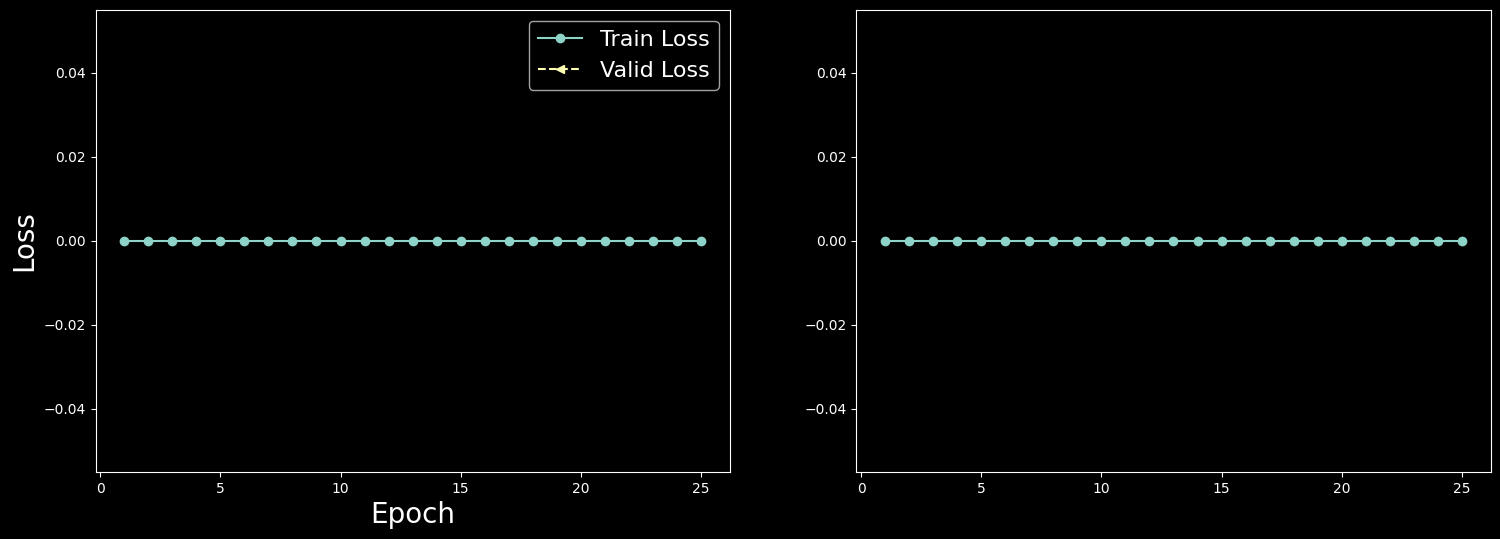

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy array if it's a list or tensor
def to_numpy(data):
    if isinstance(data, list):
        return np.array(data)
    elif hasattr(data, 'cpu'):
        return data.cpu().numpy()
    else:
        return np.array(data)

# Assuming loss_hist_train, loss_hist_valid, acc_hist_train, acc_hist_valid are defined
x_arr = np.arange(len(loss_hist_train)) + 1
fig = plt.figure(figsize=(18, 6))

# Plot loss history
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, to_numpy(loss_hist_train), '-o', label="Train Loss")
ax.plot(x_arr, to_numpy(loss_hist_valid), '--<', label="Valid Loss")
ax.legend(fontsize=16)
ax.set_xlabel("Epoch", size=20)
ax.set_ylabel("Loss", size=20)

# Plot accuracy history
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, to_numpy(acc_hist_train), '-o', label="Train Acc")
ax.plot(x_arr, to_numpy(acc_hist_valid), '--<', label="Valid Acc")  # Convert to NumPy array
ax.legend(fontsize=16)
ax.set_xlabel("Epoch", size=20)
ax.set_ylabel("Accuracy", size=20)

plt.show()


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


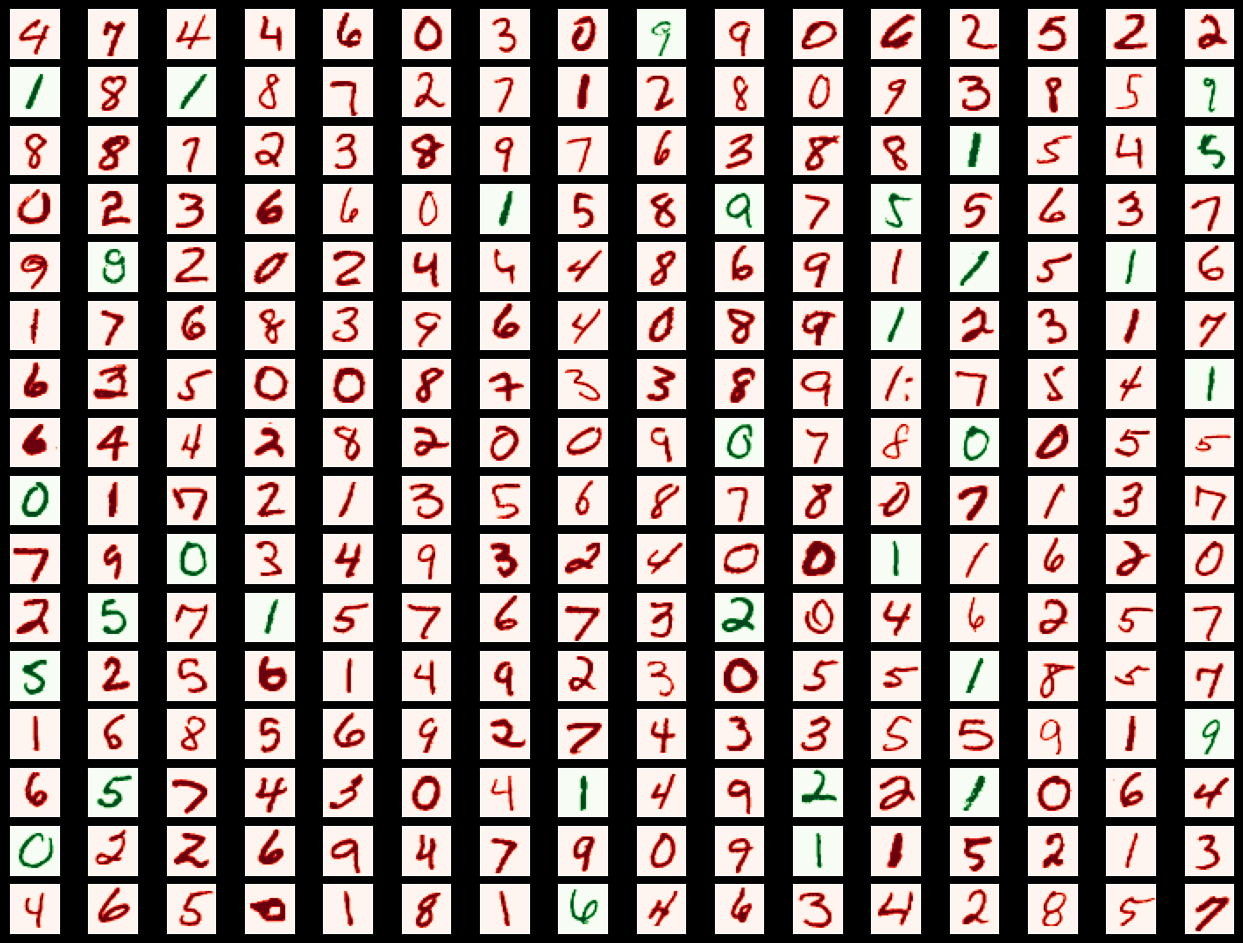

In [81]:
# Check validation set
fig = plt.figure(figsize=(16, 12))
valid_img = X_valid[:256].to(device)
if device.type == 'cuda':
    valid_img = valid_img.cuda()
pred = model(valid_img)
y_pred = torch.argmax(pred, dim=1)
for i in range(256):
    ax = fig.add_subplot(16, 16, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    img = X_valid[i].cpu().numpy().squeeze(0).astype(np.uint8)
    if y_pred[i] == y_valid[i]:
        ax.imshow(img, cmap='Greens')
    else:
        ax.imshow(img, cmap='Reds')
plt.show()

In [82]:
X_test = torch.from_numpy(df_test.to_numpy().reshape(
    (-1, 1, 28, 28)).astype(np.float32)).to(device)
X_test.shape

torch.Size([28000, 1, 28, 28])

In [83]:
test_ds = MNIST_data(X_test, X_test, DatasetType.TEST, device = device)
test_dl = DataLoader(test_ds, batch_size, shuffle=False, generator = generator)
y_preds = []
model.eval()
with torch.no_grad():
    for idx, (x_batch, y_batch) in enumerate(test_dl):
        print(f"Testing batch: {idx}",end='\r')
        pred = model(x_batch)
        y_hat = torch.argmax(pred, dim=1).tolist()
        y_preds += y_hat

In [84]:
print("Submitting csv...")
output = pd.DataFrame({'Label': y_preds}, index=[i for i in range(1, len(y_preds) + 1)])
output.index.name = 'ImageId'
output.to_csv('submission.csv')
print("Done")

Submitting csv...
Done
